In [2]:
# import dependencies
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.io import loadmat
import random

import os
from pathlib import Path

import tensorflow as tf
from tensorflow import keras

In [3]:
# load data
data = []
pathlist = Path('Samples2').glob('*.mat')
for p in pathlist:
  mat_dict = loadmat(str(p))
  data.append(mat_dict['samples'])

# shuffle data
random.shuffle(data)

In [4]:
# separate x and y data
x_values = []
y_values = []

KNOB_SET = 0.75

for d in data:
    if d[0][1][0] == KNOB_SET:
        x_values.append(d[0][0])
        y_values.append(d[0][2])

x_values = np.asarray(x_values) - 4.5
y_values = np.asarray(y_values) - 4.5
print(np.shape(x_values))
print(np.shape(y_values))

(80, 8820)
(80, 8820)


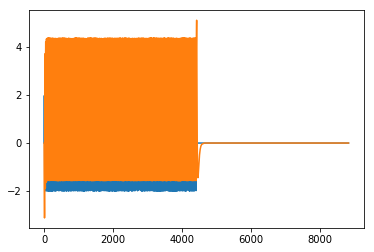

In [5]:
# plot sample data point
idx = 42
plt.plot(x_values[idx])
plt.plot(y_values[idx])
plt.show()

In [6]:
# use float32 data type...
x_values = x_values.astype(np.float32)
y_values = y_values.astype(np.float32)

In [7]:
# split into training and validation data
NUM_TRAIN = 70
NUM_VAL = 10
x_train, x_val = np.split(x_values, [NUM_TRAIN])
y_train, y_val = np.split(y_values, [NUM_TRAIN])

print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(y_train))

(70, 8820)
(10, 8820)
(70, 8820)


In [8]:
# reshape data
IN_train    = np.reshape(x_train, (NUM_TRAIN, 8820, 1))
IN_validate = np.reshape(x_val,   (NUM_VAL,   8820, 1))

OUT_train    = np.reshape(y_train, (NUM_TRAIN, 8820, 1))
OUT_validate = np.reshape(y_val,   (NUM_VAL,   8820, 1))

print(np.shape(IN_train))

(70, 8820, 1)


In [9]:
model = tf.keras.Sequential()

# GRU Layer
model.add(keras.layers.GRU(units=16, input_shape=(8820,1), return_sequences=True, bias_initializer='zeros'))

# Final layer is 1 neuron -> single value output
model.add(keras.layers.Dense(1))

# Adam optimizer
opt = keras.optimizers.Adam(learning_rate=5.0e-4)

# Error-to-Signal ratio loss function
def esr_loss(target_y, predicted_y):
  return tf.reduce_sum(tf.square(target_y - predicted_y)) / tf.reduce_sum(tf.square(target_y))

model.compile(optimizer=opt, loss=esr_loss, metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 8820, 16)          912       
_________________________________________________________________
dense (Dense)                (None, 8820, 1)           17        
Total params: 929
Trainable params: 929
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit(IN_train, OUT_train, epochs=500, validation_data=(IN_validate, OUT_validate))

Train on 70 samples, validate on 10 samples
Epoch 1/500
70/70 [==============================] - 24s 342ms/sample - loss: 1.0843 - mse: 8.6891 - val_loss: 1.1250 - val_mse: 14.5610
Epoch 2/500
70/70 [==============================] - 22s 320ms/sample - loss: 1.0704 - mse: 8.6003 - val_loss: 1.1116 - val_mse: 14.3887
Epoch 3/500
70/70 [==============================] - 22s 317ms/sample - loss: 1.0604 - mse: 8.5208 - val_loss: 1.0986 - val_mse: 14.2198
Epoch 4/500
70/70 [==============================] - 23s 326ms/sample - loss: 1.0484 - mse: 8.4329 - val_loss: 1.0858 - val_mse: 14.0543
Epoch 5/500
70/70 [==============================] - 23s 327ms/sample - loss: 1.0405 - mse: 8.3583 - val_loss: 1.0731 - val_mse: 13.8896
Epoch 6/500
70/70 [==============================] - 23s 322ms/sample - loss: 1.0303 - mse: 8.2817 - val_loss: 1.0607 - val_mse: 13.7289
Epoch 7/500
70/70 [==============================] - 23s 324ms/sample - loss: 1.0204 - mse: 8.2017 - val_loss: 1.0489 - val_mse: 13.57

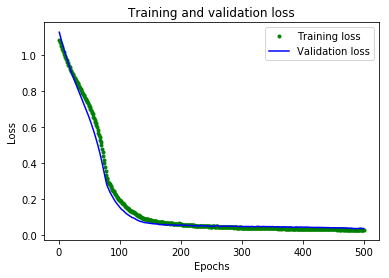

In [11]:
# plot loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

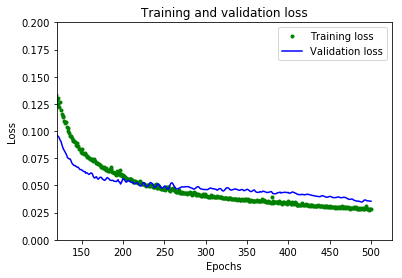

In [19]:
# plot loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim(120)
plt.ylim(0, 0.2)
plt.legend()
plt.show()

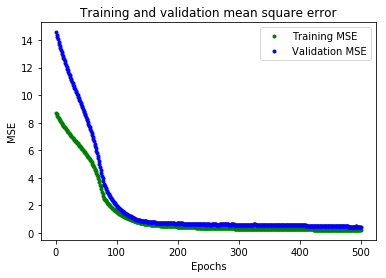

In [12]:
# plot error
plt.clf()
mse = history.history['mse']
val_mse = history.history['val_mse']

plt.plot(epochs, mse, 'g.', label='Training MSE')
plt.plot(epochs, val_mse, 'b.', label='Validation MSE')
plt.title('Training and validation mean square error')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

(1, 8820, 1)


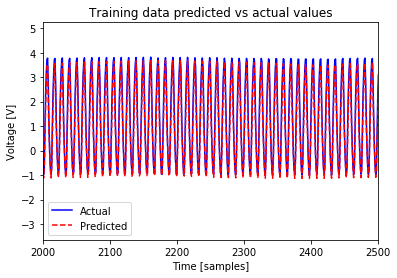

In [13]:
# Test prediction
idx = 1
predictions = model.predict(x_train[idx].reshape(1, 8820, 1))

print(np.shape(predictions))

# Plot the predictions along with to the test data
plt.clf()
plt.title('Training data predicted vs actual values')
plt.plot(y_train[idx], 'b', label='Actual')
plt.plot(predictions.flatten(), 'r--', label='Predicted')
plt.legend()
plt.xlim(2000, 2500)
plt.xlabel('Time [samples]')
plt.ylabel('Voltage [V]')
plt.show()

In [14]:
# Export weights....
print('GRU Kernel Weights...')
print(model.weights[0].numpy())

print('GRU Recurrent Weights...')
print(model.weights[1].numpy())

print('GRU bias...')
print(model.weights[2].numpy())

print('Dense Kernel Weights...')
print(model.weights[3].numpy())

print('Dense bias...')
print(model.weights[4].numpy())

GRU Kernel Weights...
[[-0.23352028  0.01205128  0.24023297 -0.11801387  0.00353205 -0.19581074
  -0.28709367 -0.20944628 -0.009259    0.11486046  0.28650624  0.40378663
  -0.30133647 -0.10530855  0.01920804  0.09276835 -0.6045199  -0.3126711
   0.19676512  0.57998234  0.19240427  0.18552192 -0.2630225  -0.34568858
   0.24113326  0.28425902  0.06733836 -0.18110734 -0.80367845 -0.39943558
  -0.06964213 -0.0932049  -0.55002767 -0.42910236 -0.11937229  0.08130345
   0.20349963  0.19693948  0.19076127 -0.26880136  0.05453877  0.02143653
  -0.5994847   0.22625706 -0.41459188 -0.25781345 -0.2958949  -0.01950309]]
GRU Recurrent Weights...
[[ 8.08230862e-02  6.83040768e-02 -2.18350530e-01  2.33595982e-01
  -5.67139149e-01  9.62043628e-02  6.34827316e-01  9.66143832e-02
  -8.04575831e-02 -3.69255811e-01  1.48741245e-01 -2.73342580e-01
   1.27923235e-01 -4.01254185e-02 -1.63416773e-01  1.94000691e-01
   2.50814229e-01  1.65265486e-01  1.08077146e-01  2.39349410e-01
   2.05513407e-02 -1.36013314e

In [15]:
model.save('Models/RNN_gain75.h5')